# ------------------------------------------------------------------------------
#
# This Example shows how to create a full project from scratch in HFSS and Icepak (linked to HFSS). the project creates
# a setup, solves it and create post processing output. It includes a lot of commands to show pyaedt Capabilities
#
# -------------------------------------------------------------------------------

In [1]:
import os
import sys
import pathlib
import clr
import glob
from IPython.display import Image

local_path = os.path.abspath('')
module_path = pathlib.Path(local_path)
aedt_lib_path = module_path.parent.parent.parent
pdf_path1 =  os.path.join(aedt_lib_path, "pyaedt", "core", "Dlls", "PDFReport")
sys.path.append(os.path.join(module_path))
sys.path.append(os.path.join(aedt_lib_path))
sys.path.append(os.path.join(pdf_path1))
from pyaedt.generic.general_methods import generate_unique_name
project_dir = os.path.join(os.environ["TEMP"], generate_unique_name("Example"))
if not os.path.exists(project_dir): os.makedirs(project_dir)
print(project_dir)


C:\Users\mcapodif\AppData\Local\Temp\Example_PEMY7P


# Import all needed Libraries

**NOTE. Numpy and Matplotlib is needed for the last part of exercise**


In [2]:
from pyaedt import Hfss
from pyaedt import Mechanical
from pyaedt import Desktop
clr.AddReference("AnsysReport")
from pyaedt.application.DataHandlers import create_table_for_csharp, create_list_for_csharp
import AnsysReport
import numpy as np
import matplotlib.pyplot as plt
import math
advanced = True


## Define Project Directory, AEDT Version and Project Name

Project will be run in Graphical Mode

In [3]:
desktopVersion = "2021.2"
NonGraphical = False
NewThread = False
project_name = "Test_Jupyter_Multiphysics"
project_file = os.path.join(project_dir, project_name + ".aedt")

## Launch Electronics Desktop and Initialize HFSS app

the command 

```Python
aedtapp = Hfss()
```


Initializes the HFSS Design in AEDT. if there is a running HFSS Design the aedtapp will be linked to it, otherwise a new design will be run.

In [4]:
desktop=Desktop(desktopVersion, NonGraphical, NewThread)
aedtapp = Hfss()

Info: Using Windows TaskManager to Load processes
Info: Ansoft.ElectronicsDesktop.2021.2 Started with Process ID 24872
Info: pyaedt v0.5.0 started
Info: Started external COM connection with module pythonnet_v3
Info: Python version 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Info: Exe path: C:\Anaconda3\python.exe
Info: Added design 'HFSS_HW6' of type HFSS
Info: Design Loaded
Info: Successfully loaded project materials !
Info: Materials Loaded


## Variables Settings

A variable can be initialized simpy by creating it as a list object. if user enter $ then the variable will be created for project otherwise for design.

In [5]:
aedtapp["$coax_dimension"] = "100mm"
aedtapp.save_project(project_file)
udp = aedtapp.modeler.Position(0, 0, 0)
coax_dimension = '$height'
aedtapp["inner"] = "3mm"

Info: Saving Project15 Project


## Modeler 
Create the Coaxial, 3 Cylinders.

Parameters can be applied directly to create_cylinder method, also material can be assigned directly to the object creation action.
Alternatively the material can be assigned usign assignmaterial function


In [6]:
id1 = aedtapp.modeler.primitives.create_cylinder(aedtapp.CoordinateSystemPlane.XYPlane, udp, "inner", "$coax_dimension",
                                                 0, "inner")
id2 = aedtapp.modeler.primitives.create_cylinder(aedtapp.CoordinateSystemPlane.XYPlane, udp, 8, "$coax_dimension",
                                                 0, matname="teflon_based")
id3 = aedtapp.modeler.primitives.create_cylinder(aedtapp.CoordinateSystemPlane.XYPlane, udp, 10, "$coax_dimension",
                                                 0, "outer")
aedtapp["$height"] = "150mm"
aedtapp.assignmaterial([id1, id3], "Copper")

Info: Assign Material copper to object inner,outer


True

## Modeler Operations

Subtract, add, etc. can be done using id of object or object name

In [7]:
aedtapp.modeler.subtract(id3, id2, True)
aedtapp.modeler.subtract(id2, id1, True)

True

## Mesh Operations



In [8]:
aedtapp.mesh.assign_initial_mesh_from_slider(6)
aedtapp.mesh.assign_model_resolution([aedtapp.modeler.primitives.get_obj_name(id1), aedtapp.modeler.primitives.get_obj_name(id3)], None)
aedtapp.mesh.assign_length_mesh(aedtapp.modeler.primitives.get_object_faces(id2), False, 1, 2000)

## Automatic Excitations Creation


In [9]:
aedtapp.create_wave_port_between_objects("inner", "outer",axisdir=0, add_pec_cap=True, portname="P1")
aedtapp.create_wave_port_between_objects("inner", "outer",axisdir=3, add_pec_cap=True, portname="P2")
portnames = aedtapp.get_all_sources()
aedtapp.modeler.fit_all()

Info: Deleted 1 Objects
Info: Deleted 1 Objects
Info: Connection Correctly created
Info: Assign Material pec to object inner_ObjectFromEdge1_1
Info: Deleted 1 Objects
Info: Deleted 1 Objects
Info: Connection Correctly created
Info: Assign Material pec to object inner_ObjectFromEdge2_1


## Setup Generation

In [10]:
aedtapp.set_active_design(aedtapp.design_name)
setup = aedtapp.create_setup("MySetup")
setup.props["Frequency"] = "1GHz"
setup.props["BasisOrder"] = 2
setup.props["MaximumPasses"] = 1
setup.update()
sweepname = aedtapp.create_frequency_sweep("MySetup", "GHz", 0.8, 1.2)

# Mechanical Model Creation
## Import model from HFSS

In [11]:
mechapp = Mechanical()

Info: Added design 'Mechanical_VRI' of type Mechanical
Info: Design Loaded
Info: Successfully loaded project materials !
Info: Materials Loaded


In [12]:
mechapp.solution_type = mechapp.SolutionTypes.Mechanical.Thermal

In [13]:
mechapp.copy_solid_bodies_from(aedtapp)

True

## Import model from HFSS

In [14]:
surfaceobj = ["inner", "outer"]
mechapp.assign_em_losses(aedtapp.design_name, "MySetup", "LastAdaptive", "1GHz", surfaceobj)

Info: Mapping HFSS EM Lossess
Info: Found 3 Objects
Info: EM losses Mapped from design HFSS_HW6


## Setup Project in Mechanical

When you create a setup, default settings will be applied
When you need to change a property of the setup you can use props command and pass the right value to the property value. The update function will apply the settings to the setup

In [15]:
aedtapp.available_variations.nominal_w_values_dict

{'inner': 0.003, '$coax_dimension': 0.1, '$height': 0.15}

In [16]:
setup_mech = mechapp.create_setup("SetupMech")


#setup_mech.add_mesh_link(aedtapp.design_name, aedtapp.nominal_adaptive, aedtapp.available_variations.nominal_w_values_dict)


In [17]:
faces = [i.id for i in mechapp.modeler.primitives["outer"].faces]
faces

[41, 33, 34, 35]

In [18]:
mechapp.assign_uniform_convection(faces, 10)


In [19]:
m=mechapp.materials.get_material("teflon_based")
m.property['youngs_modulus'].property_value[0].value = 1e6
m.property['poissons_ratio'].property_value[0].value = 0.35
m.update()

True

## Cloase and Open Projects
This command shows how to save, close and load projects. This can be helpful in case of operations on multiple projects.


In [20]:
aedtapp.save_project()
aedtapp.close_project(project_name)
aedtapp.load_project(project_file)
mechapp = Mechanical()


Info: Saving Test_Jupyter_Multiphysics Project
Info: Closing the specified Test_Jupyter_Multiphysics AEDT Project
Info: Design Loaded
Info: Successfully loaded project materials !
Info: Materials Loaded


## Solve Mechanical
Mechanical will solve also 
Solve HFSS Sweep when Mechanical is finished

In [21]:
setup1 = mechapp.analyze_setup("SetupMech")
aedtapp.save_project()
aedtapp.modeler.fit_all()
aedtapp.analyze_setup("MySetup")

Info: Solving design setup SetupMech
Info: Saving Test_Jupyter_Multiphysics Project
Info: Solving design setup MySetup


True

# Plot and Export
## Generating images and Field Plots
This section we generate Field Plots on HFSS Projects and we export it as an image
** NOTE, the generation and export of jpg works only if AEDT is launched in graphical mode **


In [22]:

results_folder = os.path.join(aedtapp.project_path,"Coaxial_Results")
if not os.path.exists(results_folder):
    os.mkdir(results_folder)   
quantity_name = "Temperature"
setup_name = mechapp.existing_analysis_setups[0]+ " : Solution"
intrinsic = mechapp.available_variations.nominal_w_values
surflist = mechapp.modeler.primitives.get_object_faces("inner")
plot4 = mechapp.post.create_fieldplot_surface(surflist, quantity_name, setup_name)
mechapp.post.export_field_image_with_View(plot4.name, os.path.join(results_folder, "FaceIso.jpg"))


True

In [23]:
mechapp.oanalysis.GetSetups()

('SetupMech',)

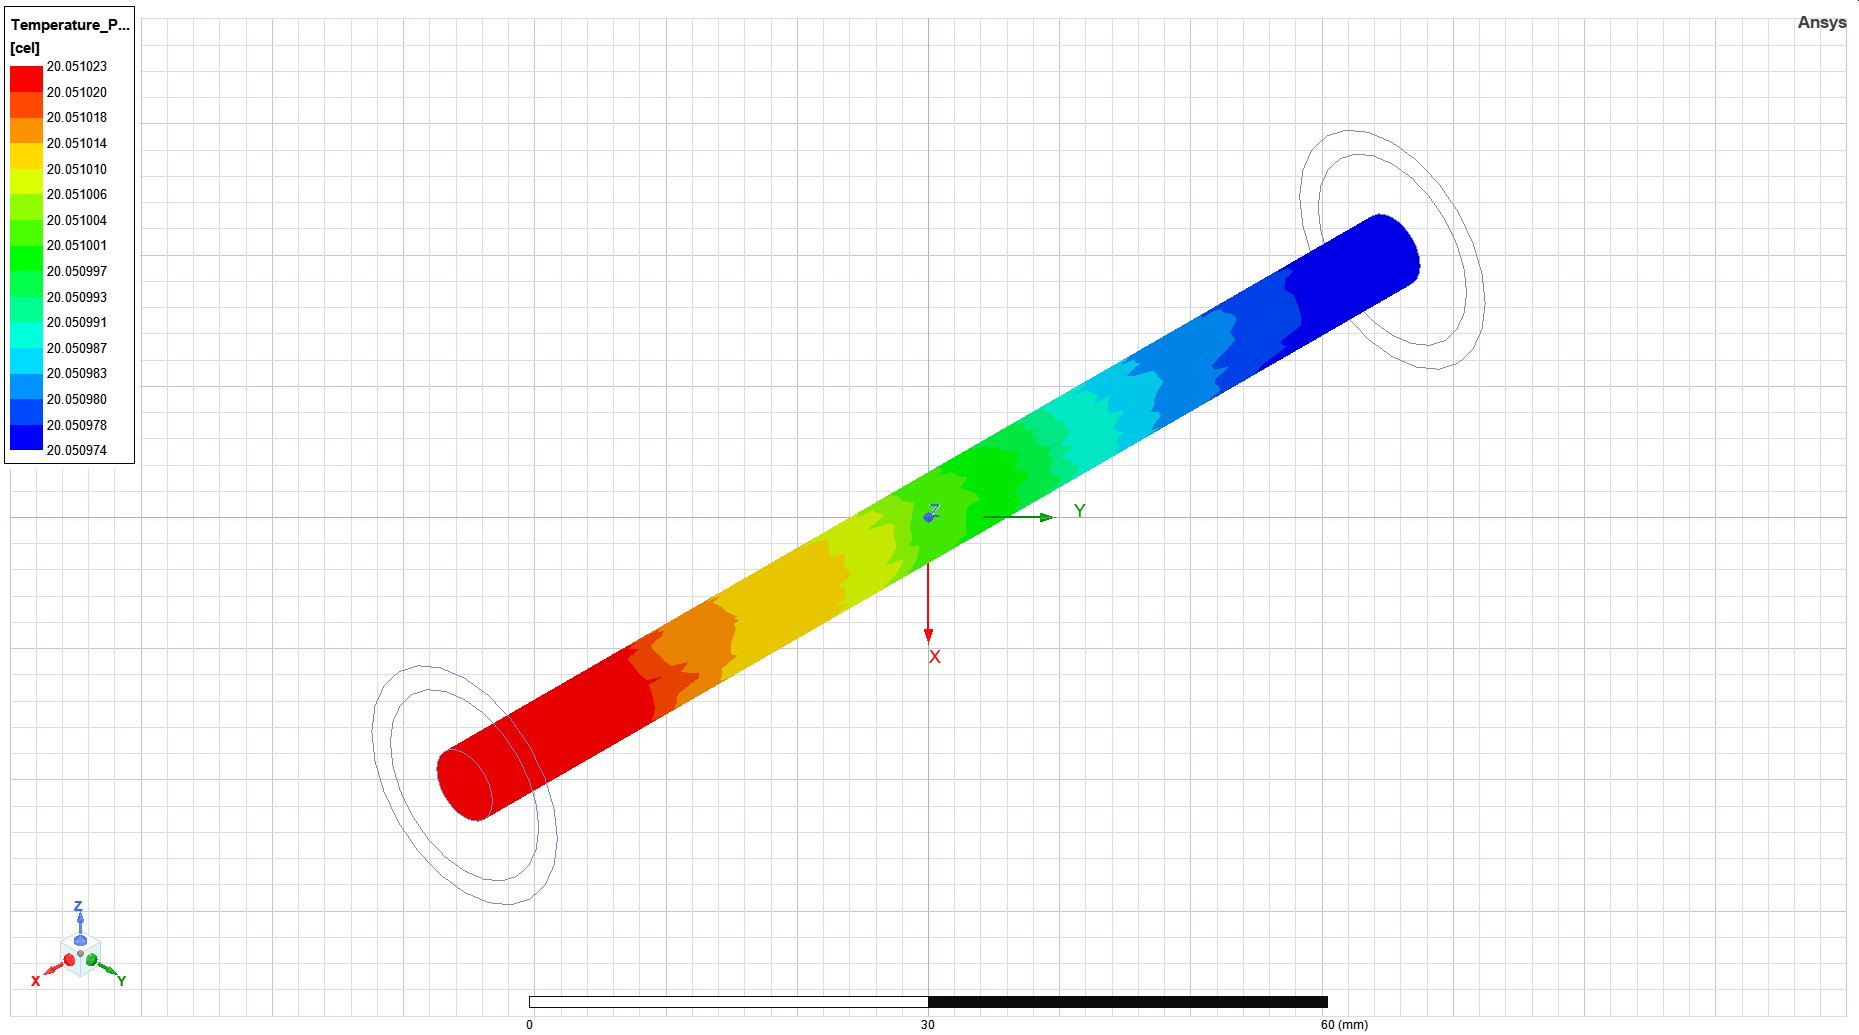

In [24]:
Image(filename=os.path.join(results_folder, "FaceIso.jpg")) 

Plotting Animation. It will open a separate UI with Animated plot. To Exit press Q

In [25]:
from pyaedt import Icepak
ipkapp = Icepak()
ipkapp.solution_type= ipkapp.SolutionTypes.Icepak.SteadyTemperatureAndFlow
ipkapp.copy_solid_bodies_from(aedtapp)


Info: Added design 'Icepak_VGN' of type Icepak
Info: Design Loaded
Info: Successfully loaded project materials !
Info: Materials Loaded


True

In [26]:
surfaceobj = ["inner", "outer"]
ipkapp.assign_em_losses(aedtapp.design_name, "MySetup", "LastAdaptive", "1GHz", surfaceobj)

Info: Mapping HFSS EM Lossess
Info: Found 4 Objects
Info: EM losses Mapped from design HFSS_HW6


In [27]:
ipkapp.edit_design_settings(aedtapp.GravityDirection.ZNeg)

True

In [28]:
setup_ipk = ipkapp.create_setup("SetupIPK")
setup_ipk.props["Convergence Criteria - Max Iterations"] = 3
setup_ipk.update()

True

In [29]:
airbox = ipkapp.modeler.primitives.get_obj_id("Region")
ipkapp.modeler.primitives[airbox].display_wireframe(True)


True

In [30]:
airfaces = ipkapp.modeler.primitives.get_object_faces(airbox)
ipkapp.assign_openings(airfaces)


Info: Face List boundary_faces created
Info: Opening Assigned


In [31]:
setup1 = ipkapp.analyze_setup("SetupIPK")
aedtapp.save_project()

Info: Solving design setup SetupIPK
Info: Saving Test_Jupyter_Multiphysics Project


True

In [32]:
mechapp2 = Mechanical(solution_type=mechapp.SolutionTypes.Mechanical.Structural)


Info: Added design 'Mechanical_21X' of type Mechanical
Info: Design Loaded
Info: Successfully loaded project materials !
Info: Materials Loaded


In [33]:
mechapp2.copy_solid_bodies_from(mechapp)

True

In [34]:
surfaceobj = ["inner", "outer"]
mechapp2.assign_thermal_map(surfaceobj, ipkapp.design_name, "SetupIPK",)

Info: Mapping HFSS EM Lossess
Info: Thermal Conditions Mapped from design Icepak_VGN


In [35]:
setup_mech = mechapp2.create_setup("SetupStruct")

In [36]:
f1 = [i.id for i in mechapp2.modeler.primitives["outer"].faces]
faces

[41, 33, 34, 35]

In [37]:
mechapp2.assign_fixed_support(f1[1])

In [38]:
mechapp2.analyze_setup("SetupStruct")

Info: Solving design setup SetupStruct


True

In [39]:
quantity_name = "Mag_Displacement"
setup_name = mechapp2.existing_analysis_setups[0]+ " : Solution"
intrinsic = mechapp2.available_variations.nominal_w_values
surflist = mechapp2.modeler.primitives.get_object_faces("inner")
plot4 = mechapp2.post.create_fieldplot_surface(surflist, quantity_name, setup_name)
mechapp2.post.export_field_image_with_View(plot4.name, os.path.join(results_folder, "DisplacementIso.jpg"))

True

# Close AEDT and Closed Project

In [40]:
aedtapp.close_project(aedtapp.project_name)
desktop.force_close_desktop()

Info: Closing the specified Test_Jupyter_Multiphysics AEDT Project
